In [ ]:
# -*- coding: utf-8 -*-
import argparse
import os
import pickle as pkl
import random

import numpy as np
import torch
# import torch.distributed
import wandb
from ase.units import GPa

from mattersim.datasets.utils.build import build_dataloader
from mattersim.forcefield.m3gnet.scaling import AtomScaling
from mattersim.forcefield.potential import Potential
from mattersim.utils.atoms_utils import AtomsAdaptor
from mattersim.utils.logger_utils import get_logger

from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt

import pandas as pd

/global/cfs/projectdirs/m4555/Jun/conda_envs/mattersim-LR/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/global/cfs/projectdirs/m4555/Jun/conda_envs/mattersim-LR/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadat

2025-11-04 12:25:02.308 | INFO     | mattersim.forcefield.potential:from_checkpoint:935 - Loading the model from ./results/last_model.pth


In [2]:
atoms_val = AtomsAdaptor.from_file(filename="../../data/benchmarks/val_water_1593_eVAng.xyz")
energies = []
forces = [] 
for atoms in atoms_val:
    energies.append(atoms.get_potential_energy() / len(atoms)) 
    forces.append(atoms.get_forces())

print(f"Processed {len(atoms_val)} validation data")

val_dataloader = build_dataloader(
    atoms_val,
    energies,
    forces,
    pin_memory=True,
    is_distributed=False,
    shuffle=False,
    batch_size=16
)

potential = Potential.from_checkpoint(
    load_path="./results/last_model.pth",
    load_training_state=False,
    long_range=True
)

predicted_energies, predicted_forces, _, charges, total_charges = potential.predict_properties(
    val_dataloader,
    include_forces=True,
    include_stresses=False
)

predicted_energies = np.array(predicted_energies) / len(atoms)

true_energies, true_forces = energies, forces

Processed 160 validation data


In [3]:
element_list = []
for i in range(len(atoms_val)):
    element_list += atoms_val[i].get_chemical_symbols()

In [4]:
df = pd.DataFrame({"Atoms": element_list, "Predicted Charges": charges})
df

,Atoms,Predicted Charges
0,O,0.002600
1,H,-0.001643
2,H,-0.001555
3,O,0.003286
4,H,-0.001481
...,...,...
30715,H,-0.001431
30716,H,-0.001517
30717,O,0.003193
30718,H,-0.001617


0.00015514658024926576


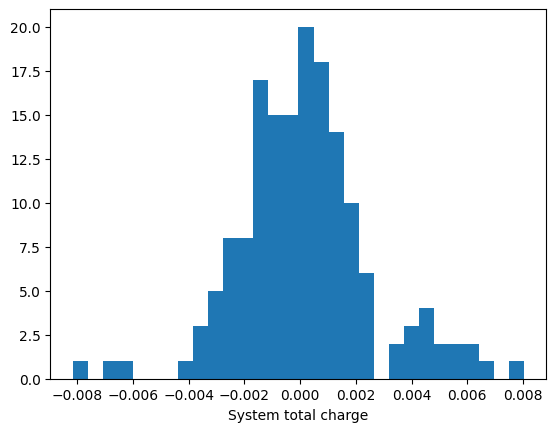

In [5]:
count = 0
system_charge = []
for i in atoms_val:
    system_charge.append(sum(df["Predicted Charges"].iloc[count:count+len(i)]))
    count += len(i)

plt.hist(np.array(system_charge), bins=30)
plt.xlabel("System total charge")
print(np.array(system_charge).mean())

2.4241653163947775e-06


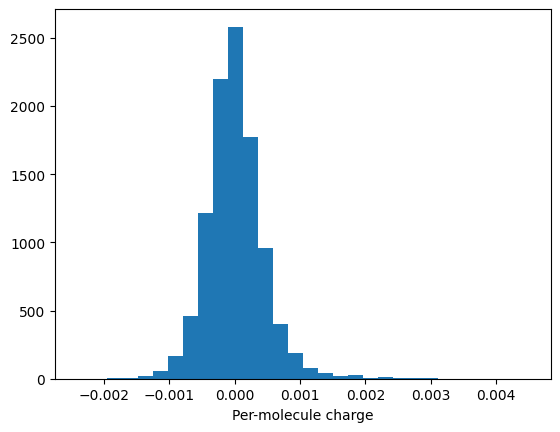

In [6]:
molecule_charge = []
for i in range(0, len(df), 3):
    molecule_charge.append(sum(df["Predicted Charges"].iloc[i:i+3]))

plt.hist(np.array(molecule_charge), bins=30)
plt.xlabel("Per-molecule charge")

print(np.array(molecule_charge).mean())

(0.0, 11644.0)

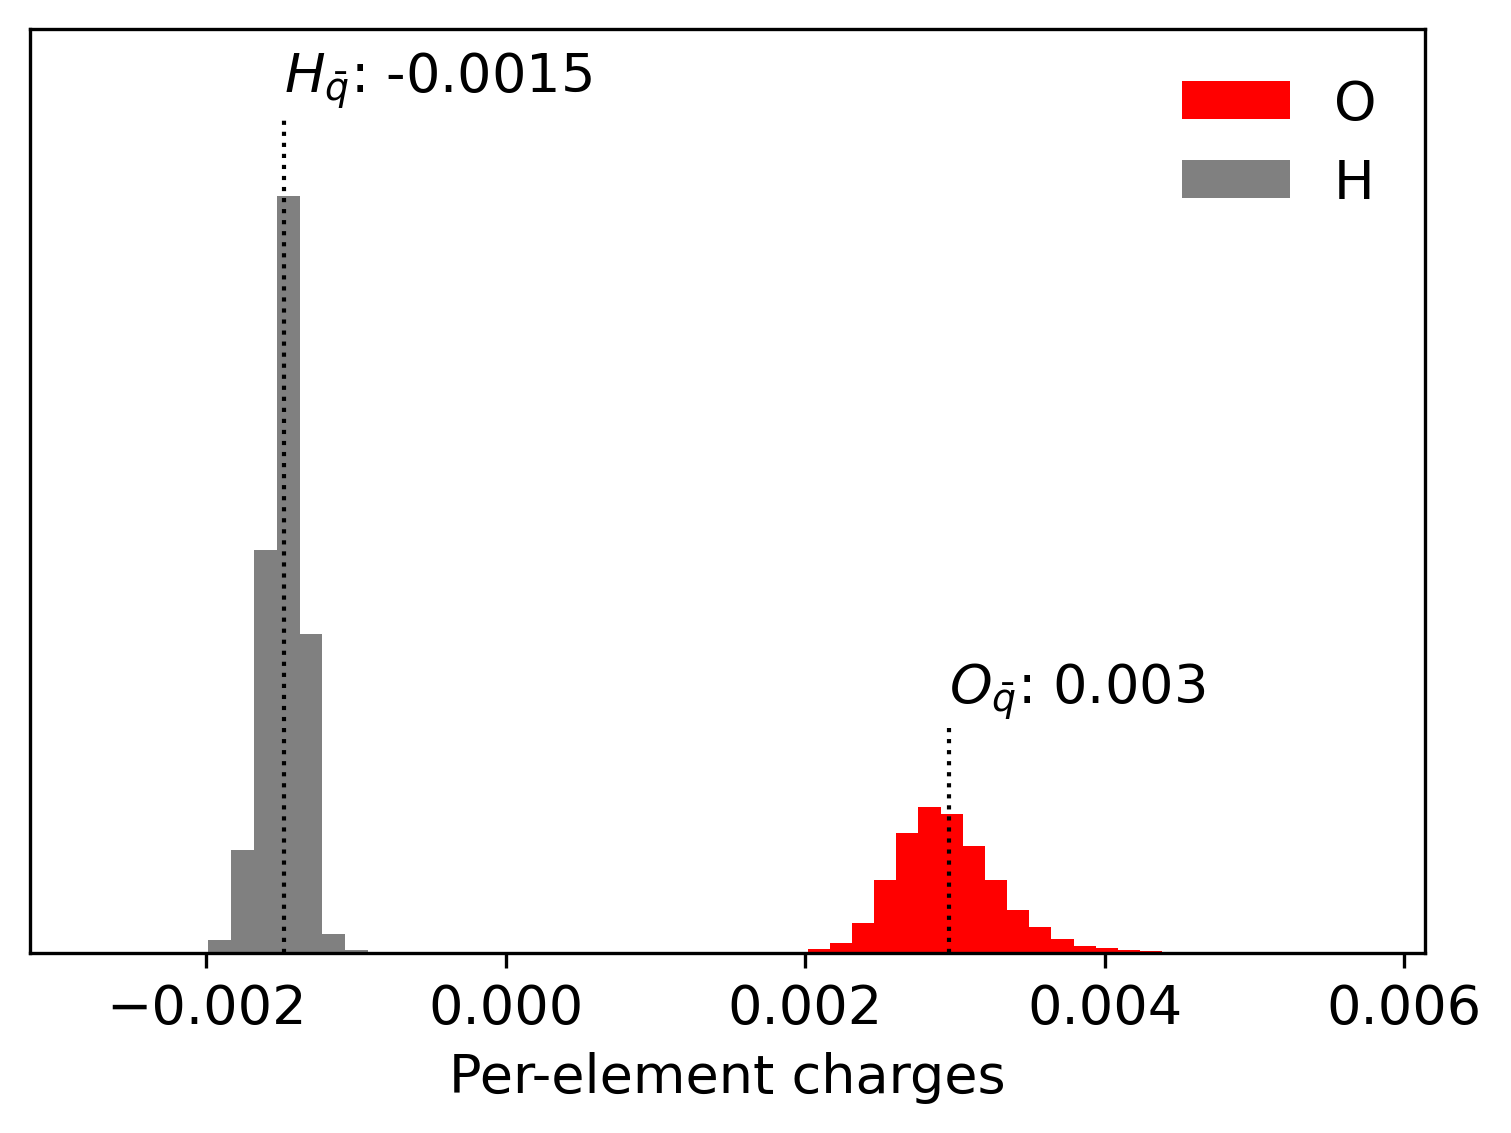

In [ ]:
O = df[df["Atoms"] == "O"]["Predicted Charges"]
H = df[df["Atoms"] == "H"]["Predicted Charges"]

plt.figure(figsize=(6,4), dpi=300)

counts_O, bins, _ = plt.hist(O, bins=30, color='red', label="O")
counts_H, bins, _ = plt.hist(H, bins=30, color ='grey', label = "H")
plt.xlabel("Per-element charges", fontsize=13)
plt.xticks(fontsize=13)
plt.yticks([])

plt.legend(frameon=False, fontsize=13)

O_mean = float(O.mean())
H_mean = float(H.mean())

plt.vlines(O_mean, 0, max(counts_O) + 1000, linestyles=':', linewidth=1, color='black')
plt.vlines(H_mean, 0, max(counts_H) + 1000, linestyles=':', linewidth=1, color='black')

plt.annotate(rf"$O_{{\bar{{q}}}}$: {round(O_mean, 4)}", (O_mean, max(counts_O) + 1300), fontsize=13)
plt.annotate(rf"$H_{{\bar{{q}}}}$: {round(H_mean, 4)}", (H_mean, max(counts_H) + 1300), fontsize=13)

plt.ylim([0, max(counts_H)+2100])